In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# Define the Inception module
def inception_module(x, filters):
    branch1 = layers.Conv2D(filters[0], (1, 1), activation='relu')(x)

    branch2 = layers.Conv2D(filters[1], (1, 1), activation='relu')(x)
    branch2 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch2)

    branch3 = layers.Conv2D(filters[3], (1, 1), activation='relu')(x)
    branch3 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch3)

    branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters[5], (1, 1), activation='relu')(branch4)

    return layers.Concatenate()([branch1, branch2, branch3, branch4])

# Define the Inception model
def create_inception_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = layers.Conv2D(64, (1, 1), activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])

    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])

    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [384, 192, 384, 48, 128, 128])

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model


In [7]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
num_classes = 10

# Create the Inception model
input_shape = (28, 28, 1)  # Input shape for MNIST images
model = create_inception_model(input_shape, num_classes)


11490434/11490434 [==============================] - 0s 0us/step


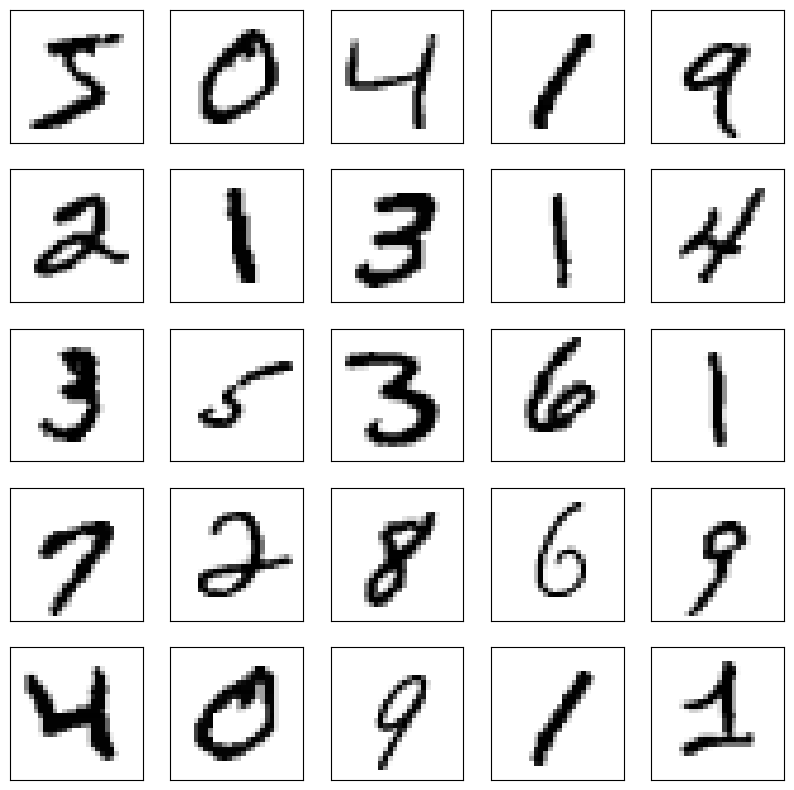

In [8]:
#Verify the data
#To verify that the dataset looks correct
#let's plot the first 25 images from the training set and display the class name below each image.
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           3200      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             4160      ['max_pooling2d[0][0]']   

In [11]:
# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 45s 41ms/step - loss: 0.9182 - accuracy: 0.6351 - val_loss: 0.1340 - val_accuracy: 0.9648
Epoch 2/10
469/469 [==============================] - 15s 31ms/step - loss: 0.1177 - accuracy: 0.9700 - val_loss: 0.0798 - val_accuracy: 0.9778
Epoch 3/10
469/469 [==============================] - 14s 31ms/step - loss: 0.0790 - accuracy: 0.9806 - val_loss: 0.0538 - val_accuracy: 0.9856
Epoch 4/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0577 - accuracy: 0.9858 - val_loss: 0.0511 - val_accuracy: 0.9880
Epoch 5/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0573 - accuracy: 0.9863 - val_loss: 0.0615 - val_accuracy: 0.9844
Epoch 6/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0474 - accuracy: 0.9886 - val_loss: 0.0710 - val_accuracy: 0.9845
Epoch 7/10
469/469 [==============================] - 15s 32ms/step - loss: 0.0445 - accuracy: 0.9894 - val_loss: 0.0476 - val_accuracy:

313/313 - 4s - loss: 0.0406 - accuracy: 0.9922 - 4s/epoch - 14ms/step
 Test Accuracy :  0.9922000169754028


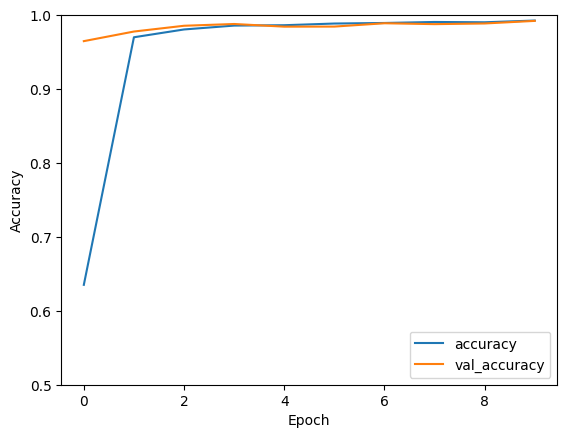

In [14]:
#Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)


print(" Test Accuracy : " , test_acc)

In [15]:
# Generate predictions on the test data
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

313/313 [==============================] - 3s 6ms/step


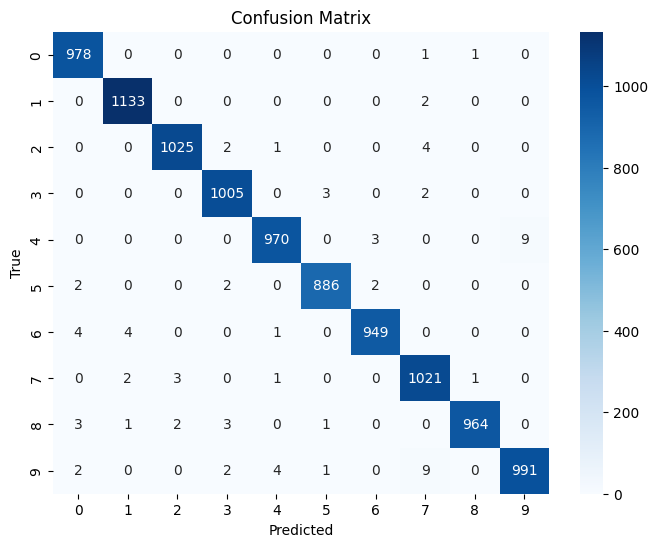

In [17]:
# Create the confusion matrix
confusion = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Print precision, recall, and F1-score
report = classification_report(y_test, predicted_labels, target_names=[str(i) for i in range(10)])
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

